In [1]:
import ktrain
from ktrain import text
import pandas as pd
import random
import numpy as np
import math

In [2]:
csv_file = '../../data/merged_ktrain_four_six_months.csv'
data = pd.read_csv(csv_file).values
print(len(data))

30500


In [3]:
epochs = 5
learning_rate = 5e-5
batch_size = 32
max_length = 10
max_words = 25000
#class_names = ['less','equal','more']
class_names = ['least','less','more','most']

In [4]:
def split_test_data(data, split=0.1, random_seed=42):
    np.random.seed(random_seed)
    np.random.shuffle(data)
    split_item = math.floor(split * len(data))
    print('split at: ', split_item)
    x_test, y_test = data[:split_item, 0], data[:split_item, 1:]
    x_train, y_train = data[split_item:, 0], data[split_item:, 1:]
    return x_train, y_train, x_test, y_test

In [5]:
x_train, y_train, x_val, y_val = split_test_data(data, split=0.15, random_seed=4242)
print(len(x_train), len(y_train), len(x_val), len(y_val))

split at:  4575
25925 25925 4575 4575


In [6]:
from sklearn.utils import class_weight
def generate_balanced_weights(y_train):
    y_labels = [y.argmax() for y in y_train]
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
    weight_dict = {}
    for key in range(len(class_weights)):
        weight_dict[key] = class_weights[key]
    return weight_dict

class_weight_dict = generate_balanced_weights(y_train)
print(class_weight_dict)

{0: 0.7830433732028512, 1: 1.1386595221363316, 2: 1.9101827291482465, 3: 0.7568901086067967}


In [7]:
MODEL ='distilbert-base-multilingual-cased'
MODEL_bert = 'bert-base-german-cased'
transformer = text.Transformer(MODEL_bert, maxlen=max_length, class_names=class_names)
train_data = transformer.preprocess_train(x_train, y_train)
val_data = transformer.preprocess_test(x_val, y_val)

preprocessing train...
language: de
train sequence lengths:
	mean : 6
	95percentile : 9
	99percentile : 11


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 6
	95percentile : 9
	99percentile : 11


In [8]:
model = transformer.get_classifier()

In [9]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=batch_size)

In [10]:
learner.fit_onecycle(5e-5, epochs=epochs, class_weight=class_weight_dict)



begin training using onecycle policy with max lr of 5e-05...
Train for 811 steps, validate for 143 steps
Epoch 1/5
811/811 [==============================] - 77s 95ms/step - loss: 1.3927 - accuracy: 0.2564 - val_loss: 1.3820 - val_accuracy: 0.2828
Epoch 2/5
811/811 [==============================] - 63s 78ms/step - loss: 1.3826 - accuracy: 0.2825 - val_loss: 1.3931 - val_accuracy: 0.2979
Epoch 3/5
811/811 [==============================] - 64s 79ms/step - loss: 1.3552 - accuracy: 0.3308 - val_loss: 1.4055 - val_accuracy: 0.3259
Epoch 4/5
811/811 [==============================] - 65s 80ms/step - loss: 1.1821 - accuracy: 0.4587 - val_loss: 1.5366 - val_accuracy: 0.3036
Epoch 5/5
811/811 [==============================] - 65s 80ms/step - loss: 0.7003 - accuracy: 0.7064 - val_loss: 2.0526 - val_accuracy: 0.3106


In [11]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)

In [12]:
confusion = learner.evaluate()

              precision    recall  f1-score   support

           0       0.39      0.30      0.34      1524
           1       0.24      0.30      0.27       971
           2       0.18      0.24      0.21       603
           3       0.37      0.36      0.37      1477

    accuracy                           0.31      4575
   macro avg       0.30      0.30      0.29      4575
weighted avg       0.32      0.31      0.31      4575



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


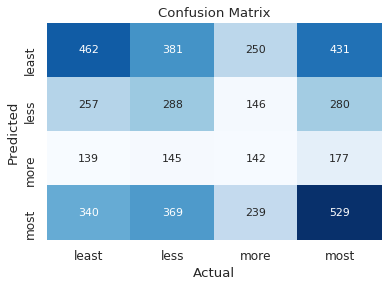

In [13]:
# print confusion matrix
import matplotlib.pyplot as plt
import seaborn as sn
labels = class_names
cm_df = pd.DataFrame(confusion, labels, labels)
sn.set(font_scale=1.1, font='Arial')
ax = sn.heatmap(cm_df, cmap="Blues", annot=True, annot_kws={"size": 11}, cbar=False, fmt='g')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()

In [14]:
confusion = learner.evaluate()

              precision    recall  f1-score   support

           0       0.39      0.30      0.34      1524
           1       0.24      0.30      0.27       971
           2       0.18      0.24      0.21       603
           3       0.37      0.36      0.37      1477

    accuracy                           0.31      4575
   macro avg       0.30      0.30      0.29      4575
weighted avg       0.32      0.31      0.31      4575

